# Industrial CO<sub>2</sub> Emission Analysis 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style('darkgrid')
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from keras.preprocessing.sequence import TimeseriesGenerator
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import logging
logging.getLogger('NeuralProphet').setLevel(logging.CRITICAL)
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics


In [21]:
#loading data

df = pd.read_csv('owid-world-data.csv')

In [22]:
df

,country,year,cement_co2,co2,coal_co2,flaring_co2,gas_co2,oil_co2
0,World,1750,NaN,9.351,9.351,NaN,NaN,NaN
1,World,1751,NaN,9.351,9.351,NaN,NaN,NaN
2,World,1752,NaN,9.354,9.354,NaN,NaN,NaN
3,World,1753,NaN,9.354,9.354,NaN,NaN,NaN
4,World,1754,NaN,9.358,9.358,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
267,World,2017,1507.923,36096.738,14506.974,391.992,7144.928,12242.628
268,World,2018,1569.218,36826.508,14746.831,412.116,7529.847,12266.017
269,World,2019,1617.507,37082.559,14725.978,439.254,7647.528,12345.653
270,World,2020,1637.537,35264.086,14174.564,407.584,7556.290,11191.809


In [23]:
ts = df[['year', 'co2']]

In [24]:
ts.rename(columns = {'year':'ds','co2':'y'}, inplace = True)


In [25]:
ts['ds'] = pd.to_datetime(ts['ds'], format='%Y')


In [26]:
ts

,ds,y
0,1750-01-01,9.351
1,1751-01-01,9.351
2,1752-01-01,9.354
3,1753-01-01,9.354
4,1754-01-01,9.358
...,...,...
267,2017-01-01,36096.738
268,2018-01-01,36826.508
269,2019-01-01,37082.559
270,2020-01-01,35264.086


In [27]:
ts.loc[ts['ds'] == '2020-01-01', 'y'] = (ts.loc[ts['ds'] == '2019-01-01', 'y'].values[0] + ts.loc[ts['ds'] == '2021-01-01', 'y'].values[0]) / 2


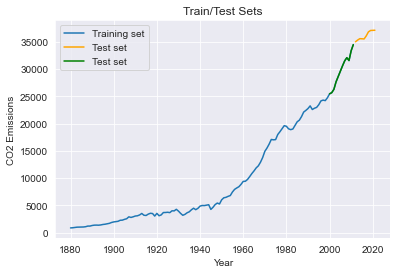

In [28]:
ts = ts[ts['ds'] > pd.Timestamp('1879-01-01')]

ts_train = ts[ts['ds'] < pd.Timestamp('2012-01-01')]
ts_val = ts[(ts['ds'] >= pd.Timestamp('2000-01-01')) & (ts['ds'] < pd.Timestamp('2012-01-01'))]
ts_test = ts[ts['ds'] >= pd.Timestamp('2012-01-01')]

plt.title('Train/Test Sets', size=12)
plt.plot(ts_train['ds'], ts_train['y'], label='Training set')
plt.plot(ts_test['ds'], ts_test['y'], label='Test set', color='orange')
plt.plot(ts_val['ds'], ts_val['y'], label='Test set', color='green')
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend();

In [29]:
m1 = NeuralProphet(changepoints_range =.9,n_forecasts=2,n_lags=1)
m1.fit(ts_train, freq = 'YS')

  0%|          | 0/109 [00:00<?, ?it/s]

  0%|          | 0/109 [00:00<?, ?it/s]

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
0,0.607381,27578.355228,38093.166406,0.560033,0.0
1,0.567967,26887.542097,35465.988431,0.510935,0.0
2,0.538954,26390.124700,34327.007001,0.469322,0.0
3,0.522125,26144.324579,32534.300962,0.439588,0.0
4,0.519829,26334.089603,31844.754147,0.422693,0.0
...,...,...,...,...,...
455,0.000095,275.605717,381.835916,0.000086,0.0
456,0.000095,274.828272,382.339247,0.000086,0.0
457,0.000095,274.587889,379.260932,0.000086,0.0
458,0.000095,274.515216,382.593843,0.000086,0.0


In [30]:
forecast_val = m1.predict(ts_val)

In [36]:
forecast1 = m1.predict(ts_test)
forecast1

,ds,y,residual1,yhat1,residual2,yhat2,ar1,ar2,trend,season_yearly
0,2012-01-01,35006.2700,NaN,None,NaN,None,None,None,None,None
1,2013-01-01,35319.2030,-473.683469,34845.519531,NaN,None,20024.097656,None,26216.9375,-11395.513672
2,2014-01-01,35577.5350,-259.163906,35318.371094,77.566562,35655.101562,20207.574219,20544.302734,26450.191406,-11339.391602
3,2015-01-01,35558.5660,202.613688,35761.179688,576.1215,36134.6875,20359.039062,20732.546875,26683.449219,-11281.307617
4,2016-01-01,35524.1910,519.156656,36043.347656,1059.184,36583.375,20347.916016,20887.947266,26916.703125,-11221.273438
5,2017-01-01,36096.7380,-13.898156,36082.839844,534.879188,36631.617188,20327.761719,20876.535156,27150.595703,-11395.513672
6,2018-01-01,36826.5080,-118.597844,36707.910156,73.808406,36900.316406,20663.453125,20855.857422,27383.849609,-11339.391602
7,2019-01-01,37082.5590,344.562094,37427.121094,453.507406,37536.066406,21091.326172,21200.269531,27617.103516,-11281.307617
8,2020-01-01,37103.2055,767.329656,37870.535156,1165.134344,38268.339844,21241.453125,21639.257812,27850.357422,-11221.273438
9,2021-01-01,37123.8520,818.444875,37942.296875,1358.167531,38482.019531,21253.558594,21793.285156,28084.251953,-11395.513672


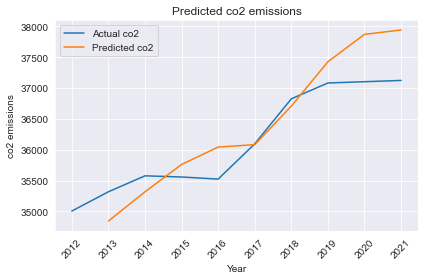

In [37]:
fig, ax = plt.subplots()


ax.plot(forecast1['ds'], forecast1['y'], label='Actual co2')
ax.plot(forecast1['ds'], forecast1['yhat1'], label='Predicted co2')


ax.set_title('Predicted co2 emissions')
ax.set_xlabel('Year')
ax.set_ylabel('co2 emissions')


ax.legend()


plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [38]:
#dropping lag
true_val_forecast = forecast_val.dropna()

In [39]:
#dropping lag
true_forecast = forecast1.dropna()

In [40]:
val_mae = mean_absolute_error(true_val_forecast['y'], true_val_forecast['yhat1'])
val_rmse = mean_squared_error(true_val_forecast['y'], true_val_forecast['yhat1'], squared=False)
val_mape = mean_absolute_percentage_error(true_val_forecast['y'], true_val_forecast['yhat1'])
val_r2 = r2_score(true_val_forecast['y'], true_val_forecast['yhat1'])

In [46]:
print('Validation Scores:')
print(f'RMSE: {val_rmse}\nMAE: {val_mae}\nMAPE: {val_mape}\nR2: {val_r2}')


Validation Scores:
RMSE: 617.4985960170724
MAE: 520.2561765625
MAPE: 0.016579728690675866
R2: 0.9352374797975991


In [42]:
m1_mae = mean_absolute_error(true_forecast['y'], true_forecast['yhat1'])
m1_rmse = mean_squared_error(true_forecast['y'], true_forecast['yhat1'], squared=False)
m1_mape = mean_absolute_percentage_error(true_forecast['y'], true_forecast['yhat1'])
m1_r2 = r2_score(true_forecast['y'], true_forecast['yhat1'])

In [49]:
print("Test Scores")
print(f'RMSE: {m1_rmse}\nMAE: {m1_mae}\nMAPE: {m1_mape}\nR2: {m1_r2}')


Test Scores
RMSE: 470.28851901080213
MAE: 380.47085937500106
MAPE: 0.010402649882018524
R2: 0.546077326462437


## Conclusions

#### Space Holder

#### Space Holder

####  Space Holder

## Next Steps
